# [Lab 11: GPU programming](@id gpu_lab)
In this lab we are going to delve into the topic of using GPU hardware in order to accelerate scientific computation. We will focus mainly on NVidia graphics hardware and it's [CUDA](https://developer.nvidia.com/cuda-zone) framework[^1], however we will no go into as much detail and thus what you learn today should be aplicable to alternative HW/frameworks such as AMD's [HIP/ROCM](https://www.amd.com/en/graphics/servers-solutions-rocm) or Intel's [oneAPI](https://www.intel.com/content/www/us/en/developer/tools/oneapi/overview.html#gs.lfd9th). We have chosen to use primarily NVidia CUDA for demonstration due to it's maturity and the availability of HW on our side.

<div class="alert alert-block alert-warning">
<b>Warning:</b> "Disclaimer"
    With the increasing complexity of GPU HW some statements may become outdated. Moreover we won't cover as many tips that you may encounter on a GPU parallel programming specific course.
</div>

## We DON'T want to get our hands dirty
We can do quite a lot without even knowing that we are using GPU instead of CPU. This marvel is the combination of Julia's multiple dispatch and array abstractions. Based on the size of the problem and intricacy of the computation we may be achieve both incredible speedups as well as slowdowns. 

The gateway to working with CUDA in Julia is the `CUDA.jl` library, which offers the following user facing functionalities
- device management `versioninfo`, `device!`
- definition of arrays on gpu `CuArray`
- data copying from host(CPU) to device(GPU) and the other way around
- wrapping already existing library code in `CuBLAS`, `CuRAND`, `CuDNN`, `CuSparse` and others
- kernel based programming (more on this in the second half of the lab)

Let's use this to inspect our GPU hardware.

In [1]:
using CUDA

In [2]:
CUDA.versioninfo()

CUDA toolkit 11.7, artifact installation
NVIDIA driver 515.65.1, for CUDA 11.7
CUDA driver 11.7

Libraries: 
- CUBLAS: 11.10.1
- CURAND: 10.2.10
- CUFFT: 10.7.2
- CUSOLVER: 11.3.5
- CUSPARSE: 11.7.3
- CUPTI: 17.0.0
- NVML: 11.0.0+515.65.1
- CUDNN: 8.30.2 (for CUDA 11.5.0)
- CUTENSOR: 1.4.0 (for CUDA 11.5.0)

Toolchain:
- Julia: 1.7.2
- LLVM: 12.0.1
- PTX ISA support: 3.2, 4.0, 4.1, 4.2, 4.3, 5.0, 6.0, 6.1, 6.3, 6.4, 6.5, 7.0
- Device capability support: sm_35, sm_37, sm_50, sm_52, sm_53, sm_60, sm_61, sm_62, sm_70, sm_72, sm_75, sm_80

1 device:
  0: Tesla V100-SXM2-32GB (sm_70, 31.745 GiB / 32.000 GiB available)


<div class="alert alert-block alert-warning">
<b>Warning:</b> "CUDA.jl compatibility": 

The latest development version of CUDA.jl requires Julia 1.6 or higher. `CUDA.jl` currently also requires a CUDA-capable GPU with compute capability 3.5 (Kepler) or higher, and an accompanying NVIDIA driver with support for CUDA 10.1 or newer. These requirements are not enforced by the Julia package manager when installing CUDA.jl. Depending on your system and GPU, you may need to install an older version of the package. [^1][]
</div>
	

[^1]: https://github.com/JuliaGPU/CUDA.jl "Disclaimer on `CUDA.jl`'s"

As we have already seen in the [lecture](@ref gpu_lecture_no_kernel), we can simply import `CUDA.jl` define some arrays, move them to the GPU and do some computation. In the following code we define two matrices `1000x1000` filled with random numbers and multiply them using usual `x * y` syntax.

In [3]:
x = randn(Float32, 60, 60)
y = randn(Float32, 60, 60)
x * y 
cx = CuArray(x)
cy = CuArray(y)
cx * cy
x * y ≈ Matrix(cx * cy)

true

This may not be anything remarkable, as such functionality is available in many other languages albeit usually with a less mathematical notation like `x.dot(y)`. With Julia's multiple dispatch, we can simply dispatch the multiplication operator/function `*` to a specific method that works on `CuArray` type. Check with `@code_typed` shows the call to CUBLAS library under the hood.

In [4]:
@code_typed cx * cy

CodeInfo(
1 ─ %1 = Base.getfield(A, :dims)::Tuple{Int64, Int64}
│   %2 = Base.getfield(%1, 1, true)::Int64
│   %3 = Base.getfield(B, :dims)::Tuple{Int64, Int64}
│   %4 = Base.getfield(%3, 2, true)::Int64
│   %5 = Core.tuple(%2, %4)::Tuple{Int64, Int64}
│   %6 = invoke CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}(CUDA.undef::UndefInitializer, %5::Tuple{Int64, Int64})::CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}
│   %7 = invoke CUDA.CUBLAS.gemm_dispatch!(%6::CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}, A::CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}, B::CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}, true::Bool, false::Bool)::CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}
└──      return %7
) => CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}

Let's now explore what the we can do with this array programming paradigm on few practical examples

<div class="alert alert-block alert-success">
<b>Exercise:</b> 
Load a sufficiently large image to the GPU such as the one provided in the lab (anything >1Mpx should be enough) and manipulate it in the following ways:
- create a negative
- half the pixel brightness
- find the brightest pixels
- get it's FFT image

Measure the runtime difference with `BenchmarkTools`. Load the image with the following code, which adds all the necessary dependencies and loads the image into Floa32 matrix.

```julia
using Pkg; 
Pkg.add(["FileIO", "ImageMagick", "ImageShow", "ColorTypes", "FFTW"])

using FileIO, ImageMagick, ImageShow, ColorTypes
rgb_img = FileIO.load("image.jpg");
gray_img = Float32.(Gray.(rgb_img));
cgray_img = CuArray(gray_img);
```

**HINTS**:
- use `Float32` everywhere for better performance
- use `CUDA.@sync` during benchmarking in order to ensure that the computation has completed

**BONUS**: Remove high frequency signal by means of modifying Fourier image.
    
<div class="alert alert-block alert-warning">
<b>Warning:</b>"Scalar indexing"
Some operations such as showing an image calls fallback implementation which requires `getindex!` called from the CPU. As such it is incredibly slow and should be avoided. In order to show the image use `Array(cimg)` to move it as a whole. Another option is to suppress the output with semicolon
    
```julia
julia> cimg
┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007f25931b6380.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArrays ~/.julia/packages/GPUArrays/gkF6S/src/host/indexing.jl:56
julia> Array(cimg)
Voila!
julia> cimg;
```
</div> 
    
</div>

In [5]:
using Pkg; 
Pkg.add(["FileIO", "ImageMagick", "ImageShow", "ColorTypes", "FFTW"])

using FileIO, ImageMagick, ImageShow, ColorTypes
rgb_img = FileIO.load("out.png");# image.jpg
gray_img = Float32.(Gray.(rgb_img));
cgray_img = CuArray(gray_img);

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


StableDiffusion generated image

<img src="./out.png" align="center" width="70%"> [^2][]

[^2]: https://replicate.com/api/models/cjwbw/stable-diffusion-high-resolution/files/e1b194af-e903-4efb-8bb2-8016b0863507/out.png "StableDiffusion generated image"

<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

#### 

In [6]:
negative(i) = 1.0f0 .- i
darken(i) = i .* 0.5f0
using CUDA.CUFFT
using FFTW
fourier(i) = fft(i)
brightest(i) = findmax(i)

brightest (generic function with 1 method)

Benchmarking

In [7]:
using BenchmarkTools

In [8]:
@btime CUDA.@sync negative($cgray_img);

  24.011 μs (16 allocations: 784 bytes)


In [9]:
@btime negative($gray_img);

  455.071 μs (2 allocations: 4.00 MiB)


In [10]:
@btime CUDA.@sync darken($cgray_img);

  23.884 μs (16 allocations: 784 bytes)


In [11]:
@btime darken($gray_img);

  471.332 μs (2 allocations: 4.00 MiB)


In [12]:
@btime CUDA.@sync fourier($cgray_img);

  135.857 μs (48 allocations: 2.19 KiB)


In [13]:
@btime fourier($gray_img);

  21.795 ms (34 allocations: 16.00 MiB)


In [14]:
@btime CUDA.@sync brightest($cgray_img);

  52.200 μs (45 allocations: 2.36 KiB)


In [15]:
@btime brightest($gray_img);

  3.911 ms (0 allocations: 0 bytes)


In the next example we will try to solve a system of linear equations $Ax=b$, where A is a large (possibly sparse) matrix.

<div class="alert alert-block alert-success">
<b>Exercise:</b> 
    
Benchmark the solving of the following linear system with `N` equations and `N` unknowns. Experiment with increasing `N` to find a value , from which the advantage of sending the matrix to GPU is significant (include the time of sending the data to and from the device). For the sake of this example significant means 2x speedup. At what point the memory requirements are incompatible with your hardware, i.e. exceeding the memory of a GPU?

```julia
α = 10.0f0
β = 10.0f0

function init(N, α, β, r = (0.f0, π/2.0f0))
    dx = (r[2] - r[1]) / N
    A = zeros(Float32, N+2, N+2)
    A[1,1] = 1.0f0
    A[end,end] = 1.0f0
    for i in 2:N+1
        A[i,i-1] = 1.0f0/(dx*dx)
        A[i,i] = -2.0f0/(dx*dx) - 16.0f0
        A[i,i+1] = 1.0f0/(dx*dx)
    end

    b = fill(-8.0f0, N+2)
    b[1] = α
    b[end] = β
    A, b
end

N = 30
A, b = init(N, α, β)
```

**HINTS**:
- use backslash operator `\` to solve the system
- use `CuArray` and `Array` for moving the date to and from device respectively
- use `CUDA.@sync` during benchmarking in order to ensure that the computation has completed

**BONUS 1**: Visualize the solution `x`. What may be the origin of our linear system of equations?
**BONUS 2**: Use sparse matrix `A` to achieve the same thing. Can we exploit the structure of the matrix for more effective solution?
</div>

In [16]:
α = 10.0f0
β = 10.0f0

function init(N, α, β, r = (0.f0, π/2.0f0))
    dx = (r[2] - r[1]) / N
    A = zeros(Float32, N+2, N+2)
    A[1,1] = 1.0f0
    A[end,end] = 1.0f0
    for i in 2:N+1
        A[i,i-1] = 1.0f0/(dx*dx)
        A[i,i] = -2.0f0/(dx*dx) - 16.0f0
        A[i,i+1] = 1.0f0/(dx*dx)
    end

    b = fill(-8.0f0, N+2)
    b[1] = α
    b[end] = β
    A, b
end

<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

#### 

## N=30

In [ ]:
N = 30;
A, b = init(N, α, β)
cA, cb = CuArray(A), CuArray(b)
A\b
cA\cb;

In [ ]:
@btime $A \ $b;

In [ ]:
@btime CUDA.@sync $cA \ $cb;

## N=3000

In [34]:
N = 3000;
A, b = init(N, α, β)
cA, cb = CuArray(A), CuArray(b)
A\b
cA\cb;

In [35]:
@btime $A \ $b;

  45.195 ms (5 allocations: 34.41 MiB)


In [37]:
#@btime CUDA.@sync Array(CuArray($A) \ CuArray($b));
@btime CUDA.@sync $cA \ $cb;

  25.409 ms (141 allocations: 8.06 KiB)


**BONUS 1**:
The system comes from a solution of second order ODR with *boundary conditions*.

**BONUS 2**:
The matrix is tridiagonal, therefore we don't have to store all the entries.

Programming GPUs in this way is akin to using NumPy, MATLAB and other array based toolkits, which force users not to use for loops. There are attempts to make GPU programming in Julia more powerful without delving deeper into writing of GPU kernels. One of the attempts is [`Tulio.jl`](https://github.com/mcabbott/Tullio.jl), which uses macros to annotate parallel for loops, similar to [`OpenMP`](https://www.openmp.org/)'s `pragma` intrinsics, which can be compiled to GPU as well.

Note also that Julia's `CUDA.jl` is not a tensor compiler. With the exception of broadcast fusion, which is easily transferable to GPUs, there is no optimization between different kernels from the compiler point of view. Furthermore, memory allocations on GPU are handled by Julia's GC, which is single threaded and often not as aggressive, therefore similar application code can have different memory footprints on the GPU.

Nowadays there is a big push towards simplifying programming of GPUs, mainly in the machine learning community, which often requires switching between running on GPU/CPU to be a one click deal. However this may not always yield the required results, because the GPU's computation model is different from the CPU, see [lecture](@ref gpu_lecture). This being said Julia's `Flux.jl` framework does offer such capabilities [^2][]

```julia
using Flux, CUDA
m = Dense(10,5) |> gpu
x = rand(10) |> gpu
y = m(x)
y |> cpu
```

[^2]: https://fluxml.ai/Flux.jl/stable/gpu/#GPU-Support "Taken from `Flux.jl`"

## We DO want to get our hands dirty
There are two paths that lead to the necessity of programming GPUs more directly via kernels
1. We cannot express our algorithm in terms of array operations.
2. We want to get more out of the code,

Note that the ability to write kernels in the language of your choice is not granted, as this club includes a limited amount of members - C, C++, Fortran and Julia. Consider then the following comparison between `CUDA C` and `CUDA.jl` implementation of a simple vector addition kernels as seen in the [lecture](@ref gpu_lecture_yes_kernel). Which one would you choose?

```c
#define cudaCall(err) // check return code for error
#define frand() (float)rand() / (float)(RAND_MAX)

__global__ void vadd(const float *a, const float *b, float *c) {
	int i = blockIdx.x * blockDim.x + threadIdx.x;
	c[i] = a[i] + b[i];
}

const int len = 100;
int main() {
	float *a, *b;
	a = new float[len];
	b = new float[len];
	for (int i = 0; i < len; i++) {
		a[i] = frand(); b[i] = frand();
	}
	float *d_a, *d_b, *d_c;
	cudaCall(cudaMalloc(&d_a, len * sizeof(float)));
	cudaCall(cudaMemcpy(d_a, a, len * sizeof(float), cudaMemcpyHostToDevice));
	cudaCall(cudaMalloc(&d_b, len * sizeof(float)));

	cudaCall(cudaMemcpy(d_b, b, len * sizeof(float), cudaMemcpyHostToDevice));
	cudaCall(cudaMalloc(&d_c, len * sizeof(float)));

	vadd<<<1, len>>>(d_a, d_b, d_c);

	float *c = new float[len];
	cudaCall(cudaMemcpy(c, d_c, len * sizeof(float), cudaMemcpyDeviceToHost));
	cudaCall(cudaFree(d_c));
	cudaCall(cudaFree(d_b));
	cudaCall(cudaFree(d_a));

	return 0;
}
```
Compared to CUDA C the code is less bloated, while having the same functionality.[^4]

In [38]:
function vadd(a, b, c)
	i = (blockIdx().x-1) * blockDim().x + threadIdx().x
	c[i] = a[i] + b[i]
	return
end

len = 100
a = rand(Float32, len);
b = rand(Float32, len);
d_a = CuArray(a);
d_b = CuArray(b);
d_c = similar(d_a);
@cuda threads = (1, len) vadd(d_a, d_b, d_c);
c = Array(d_c);



[^4]: This comparison is not fair to `CUDA C`, where memory management is left to the user and all the types have to be specified. However at the end of the day the choice of a high level language makes more sense as it offers the same functionality and is far more approachable.

### CUDA programming model
Recalling from the lecture, in CUDA programming model, you usually write kernels, which represent the body of some parallel for loop. 
- A kernel is executed on multiple threads, which are grouped into thread blocks. 
- All threads in a block are executed in the same Streaming Multi-processor (SM), having access to some shared pool of memory. 
- The number of threads launched is always a multiple of 32 (32 threads = 1 warp, therefore length of a thread block should be divisible by 32). 
- All threads in a single warps are executed simultaneously. 
- We have to take care of how many threads will be launched in order to complete the task at hand, i.e. if there are insufficiently many threads/blocks spawned we may end up doing only part of the task. 
- We can spawn threads/thread blocks in both in 1D, 2D or 3D blocks, which may ease the indexing inside the kernel when dealing with higher dimensional data.


#### Thread indexing
Stopping for a moment here to illustrate the last point with a visual aid[^5]
<img src="./grid_block_thread.png" align="center" width="80%">

[^5]: The number of blocks to be run are given by the grid dimension. Image taken from http://tdesell.cs.und.edu/lectures/cuda_2.pdf

This explains the indexing into a linear array from above
```julia
i = (blockIdx().x-1) * blockDim().x + threadIdx().x
```
which is similar to the computation a linear index of multidimensional (in our case 2D array row ~ `blockIdx` and column `threadIdx`). Again let's use a visual help for this 1D vector[^6]
<img src="./thread_index.png" align="center" width="80%">

[^6]: https://developer-blogs.nvidia.com/wp-content/uploads/2017/01/cuda_indexing-1024x463.png "Taken from"

#### Launching a kernel

Let's now dig into what is happening during execution of the line `@cuda threads = (1, len) vadd(d_a, d_b, d_c)`:
1. Compile the `vadd` kernel to GPU code (via LLVM and it's [NVPTX backend](https://www.llvm.org/docs/NVPTXUsage.html))
2. Parse and construct launch configuration of the kernel. Here we are creating `1` thread block with `1x100` threads (in reality 128 threads may be launched).
3. Schedule to run `vadd` kernel with constructed launch configuration and arguments.
4. Return the task status.

It's important to stress that we only schedule the kernel to run, however in order to get the result we have to first wait for the completion. This can be done either via
- `CUDA.@sync`, which we have already seen earlier
- or a command to copy result to host (`Array(c)`), which always synchronizes kernels beforehand




<div class="alert alert-block alert-success">
<b>Exercise:</b> 
    
Fix the `vadd` kernel such that it can work with different launch configurations, such as
```julia
@cuda threads=64 blocks=2 vadd(d_a, d_b, d_c)
@cuda threads=32 blocks=4 vadd(d_a, d_b, d_c)
```
Is there some performance difference? Try increasing the size and corresponding number of blocks to cover the larger arrays.

What happens if we launch the kernel in the following way?
```julia
@cuda threads=32 blocks=2 vadd(d_a, d_b, d_c)
```

Write a wrapper function `vadd_wrap(a::CuArray, b::CuArray)` for `vadd` kernel, such that it spawns the right amount of threads and returns only when the kernels has finished.

<div class="alert alert-block alert-warning">
<b>Warning:</b>  "Wrapping kernels"
A usual patter that you will see in GPU related code is that the kernel is written inside a function
    
```julia
function do_something(a,b)
    function do_something_kernel!(c,a,b)
        ...
    end

    # handle allocation
    # handle launch configuration
    @cuda ... do_something_kernel!(c,a,b)
end
```
Note that there are hardware limitations as to how many threads can be scheduled on a GPU. You can check it with the following code
    
```julia
k = @cuda vadd(d_a, d_b, d_c)
CUDA.maxthreads(k)
```
</div>

**HINTS**:
- if you don't know what is wrong with the current implementation just try it, but be warned that you might need to restart Julia after that
- don't forget to use `CUDA.@sync` when benchmarking
- you can inspect the kernel with analogs of `@code_warntype` ~ `@device_code_warntype @cuda vadd(d_a, d_b, d_c)`
- lookup `cld` function for computing the number of blocks when launching kernels on variable sized input


</div>

In [43]:
k = @cuda vadd(d_a, d_b, d_c)
CUDA.maxthreads(k)

1024

In [58]:
#@cuda threads=64 blocks=2 vadd(d_a, d_b, d_c);
#@cuda threads=32 blocks=4 vadd(d_a, d_b, d_c);
#@cuda threads=32 blocks=2 vadd(d_a, d_b, d_c);

<div class="alert alert-block alert-info">
<b>Solution</b>: </div>


#### 

In order to fix the out of bounds accesses we need to add manual bounds check, otherwise we may run into some nice Julia crashes.



In [44]:
function vadd(a, b, c)
	i = (blockIdx().x-1) * blockDim().x + threadIdx().x
    if i <= length(c)
	    c[i] = a[i] + b[i]
    end
	return
end

vadd (generic function with 1 method)

Launching kernel with insufficient number of threads leads to only partial results.

In [45]:
d_c = similar(d_a)
@cuda threads=32 blocks=2 vadd(d_a, d_b, d_c) # insufficient number of threads
Array(d_c)

100-element Vector{Float32}:
 1.125047
 1.3578109
 1.2934387
 0.5850325
 1.200075
 1.2683887
 0.22579598
 0.3920558
 1.0304948
 0.8387232
 1.1997668
 1.4935739
 0.54234016
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

Benchmarking different implementation shows that in this case running more threads per block may be beneficial, however only up to some point.



In [46]:
len = 10_000
a = rand(Float32, len)
b = rand(Float32, len)
d_a = CuArray(a)
d_b = CuArray(b)
d_c = similar(d_a);

In [48]:
@btime CUDA.@sync @cuda threads=256 blocks=cld(len, 256) vadd($d_a, $d_b, $d_c);

  12.540 μs (26 allocations: 1.31 KiB)


In [49]:
@btime CUDA.@sync @cuda threads=128 blocks=cld(len, 128) vadd($d_a, $d_b, $d_c);

  10.728 μs (26 allocations: 1.31 KiB)


In [50]:
@btime CUDA.@sync @cuda threads=64 blocks=cld(len, 64) vadd($d_a, $d_b, $d_c);

  10.826 μs (26 allocations: 1.31 KiB)


In [51]:
@btime CUDA.@sync @cuda threads=32 blocks=cld(len, 32) vadd($d_a, $d_b, $d_c);

  11.222 μs (26 allocations: 1.31 KiB)


The launch configuration depends heavily on user's hardware and the actual computation in the kernel, where in some cases having more threads in a block is better (up to some point).


### Image processing with kernels
Following up on exercise with image processing let's use kernels for some functions that cannot be easily expressed as array operations.

<div class="alert alert-block alert-success">
<b>Exercise:</b> 

implement `translate_kernel!(output, input, translation)` , which translates an image `input` in the direction of `translation` tuple (values given in pixels). The resulting image should be stored in `output`. Fill in the empty space with zeros.

**HINTS**:
- use 2D grid of threads and blocks to simplify indexing
- check all sides of an image for out of bounds accesses

**BONUS**: In a similar fashion you can create `scale_kernel!`, `rotate_kernel!` for scaling and rotation of an image.

</div>


<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

In [52]:
using CUDA
function translate_kernel!(output, input, translation)
    x_idx = (blockIdx().x-1) * blockDim().x + threadIdx().x
    y_idx = (blockIdx().y-1) * blockDim().y + threadIdx().y

    x_outidx = x_idx + translation[1]
    y_outidx = y_idx + translation[2]

    if (1 <= x_outidx <= size(output,1)) && 
        (1 <= y_outidx <= size(output,2)) && 
        (x_idx <= size(output,1)) && (y_idx <= size(output,2))
        output[x_outidx, y_outidx] = input[x_idx, y_idx]
    end

    return
end

translate_kernel! (generic function with 1 method)

In [53]:
using FileIO, ImageMagick, ImageShow, ColorTypes
rgb_img = FileIO.load("out.png");
gray_img = Float32.(Gray.(rgb_img));
cgray_img = CuArray(gray_img);
cgray_img_moved = CUDA.fill(0.0f0, size(cgray_img));

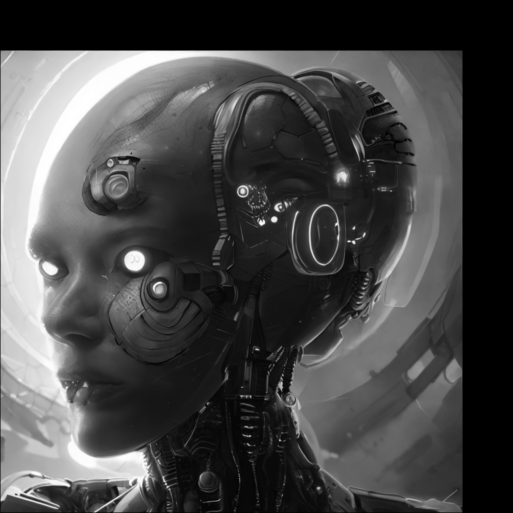

In [54]:
blocks = cld.((size(cgray_img,1), size(cgray_img,2)), 32)
@cuda threads=(32, 32) blocks=blocks translate_kernel!(cgray_img_moved, cgray_img, (100, -100))
Gray.(Array(cgray_img_moved))

In [ ]:
# too many threads per block (fails on some weird exception) - CUDA error: invalid argument (code 1, ERROR_INVALID_VALUE)
#@cuda threads=(64, 64) blocks=(1,1) translate_kernel!(cgray_img_moved, cgray_img, (-500, 500)) 

### Profiling
CUDA framework offers a wide variety of developer tooling for debugging and profiling our own kernels. In this section we will focus profiling using the Nsight Systems software that you can download after registering [here](https://developer.nvidia.com/nsight-systems). It contains both `nsys` profiler as well as `nsys-ui`GUI application for viewing the results. First we have to run `julia` using `nsys` application.
- on Windows with PowerShell (available on the lab computers)
```ps
& "C:\Program Files\NVIDIA Corporation\Nsight Systems 2021.2.4\target-windows-x64\nsys.exe" launch --trace=cuda,nvtx H:/Downloads/julia-1.6.3/bin/julia.exe --color=yes --color=yes --project=$((Get-Item .).FullName)
```
- on Linux
```bash
/full/path/to/nsys launch --trace=cuda,nvtx /home/honza/Apps/julia-1.6.5/bin/julia --color=yes --project=.
```
Once `julia` starts we have to additionally (on the lab computers, where we cannot modify env path) instruct `CUDA.jl`, where `nsys.exe` is located.
```julia
ENV["JULIA_CUDA_NSYS"] = "C:\\Program Files\\NVIDIA Corporation\\Nsight Systems 2021.2.4\\target-windows-x64\\nsys.exe"
```
Now we should be ready to start profiling our kernels.

<div class="alert alert-block alert-success">
<b>Exercise:</b> 

Choose a function/kernel out of previous exercises, in order to profile it. Use the `CUDA.@profile` macro the following patter to launch profiling of a block of code with `CUDA.jl`
```julia
CUDA.@profile CUDA.@sync begin 
    NVTX.@range "something" begin
    		# run some kernel
    end 

    NVTX.@range "something" begin
    		# run some kernel
    end 
end
```
where `NVTX.@range "something"` is part of `CUDA.jl` as well and serves us to mark a piece of execution for better readability later. Inspect the result in `NSight Systems`.

<div class="alert alert-block alert-warning">
<b>Warning:</b> "Profiling overhead"
	It is recommended to run the code twice as shown above, because the first execution with profiler almost always takes longer, even after compilation of the kernel itself. 
</div>
</div>

<details class = "solution-body">
<summary class = "solution-header">Solution:</summary><p>
In order to show multiple kernels running let's demonstrate profiling of the first image processing exercise

```julia
CUDA.@profile CUDA.@sync begin
    NVTX.@range "copy H2D" begin
        rgb_img = FileIO.load("image.jpg");
        gray_img = Float32.(Gray.(rgb_img));
        cgray_img = CuArray(gray_img);
    end

    NVTX.@range "negative" begin 
        negative(cgray_img);
    end
    NVTX.@range "darken" begin 
        darken(cgray_img);
    end
    NVTX.@range "fourier" begin 
        fourier(cgray_img);
    end
    NVTX.@range "brightest" begin 
        brightest(cgray_img);
    end
end
```
Running this code should create a report in the current directory with the name `report-**.***`, which we can examine in `NSight Systems`.




<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

In order to show multiple kernels running let's demonstrate profiling of the first image processing exercise

In [55]:
CUDA.@profile CUDA.@sync begin
    NVTX.@range "copy H2D" begin
        rgb_img = FileIO.load("out.png");
        gray_img = Float32.(Gray.(rgb_img));
        cgray_img = CuArray(gray_img);
    end

    NVTX.@range "negative" begin 
        negative(cgray_img);
    end
    NVTX.@range "darken" begin 
        darken(cgray_img);
    end
    NVTX.@range "fourier" begin 
        fourier(cgray_img);
    end
    NVTX.@range "brightest" begin 
        brightest(cgray_img);
    end
end

┌ Warning: Calling CUDA.@profile only informs an external profiler to start.
│ The user is responsible for launching Julia under a CUDA profiler.
│ 
│ It is recommended to use Nsight Systems, which supports interactive profiling:
│ $ nsys launch julia
└ @ CUDA.Profile /home/zorekmat/.julia/packages/CUDA/Ey3w2/lib/cudadrv/profile.jl:82


(1.0f0, CartesianIndex(260, 169))

### Matrix multiplication

<div class="alert alert-block alert-success">
<b>Exercise:</b> 
    
Write a generic matrix multiplication `generic_matmatmul!(C, A, B)`, which wraps a GPU kernel inside. For simplicity assume that both `A` and `B` input matrices have only `Float32` elements. Benchmark your implementation against `CuBLAS`'s `mul!(C,A,B)`.

**HINTS**:
- use 2D blocks for easier indexing
- import `LinearAlgebra` to be able to directly call `mul!`
- in order to avoid a headache with the choice of launch config use the following code
```julia
max_threads = 256
threads_x = min(max_threads, size(C,1))
threads_y = min(max_threads ÷ threads_x, size(C,2))
threads = (threads_x, threads_y)
blocks = ceil.(Int, (size(C,1), size(C,2)) ./ threads)
```
</div>



<details class = "solution-body">
<summary class = "solution-header">Solution:</summary><p>

Adapted from the `CUDA.jl` source [code](https://github.com/JuliaGPU/CuArrays.jl/blob/cee6253edeca2029d8d0522a46e2cdbb638e0a50/src/matmul.jl#L4-L50).

```julia
function generic_matmatmul!(C, A, B)
    function kernel(C, A, B)
        i = (blockIdx().x-1) * blockDim().x + threadIdx().x
        j = (blockIdx().y-1) * blockDim().y + threadIdx().y

        if i <= size(A,1) && j <= size(B,2)
            Ctmp = 0.0f0
            for k in 1:size(A,2)
                Ctmp += A[i, k]*B[k, j]
            end
            C[i,j] = Ctmp
        end

        return
    end

    max_threads = 256
    threads_x = min(max_threads, size(C,1))
    threads_y = min(max_threads ÷ threads_x, size(C,2))
    threads = (threads_x, threads_y)
    blocks = ceil.(Int, (size(C,1), size(C,2)) ./ threads)

    @cuda threads=threads blocks=blocks kernel(C, A, B)

    C
end

K, L, M = 10 .* (200, 100, 50)
A = CuArray(randn(K, L));
B = CuArray(randn(L, M));
C = similar(A, K, M);

generic_matmatmul!(C, A, B)

using LinearAlgebra
CC = similar(A, K, M)
mul!(CC, A, B)


using BenchmarkTools
@btime CUDA.@sync generic_matmatmul!(C, A, B);
@btime CUDA.@sync mul!(CC, A, B);




<div class="alert alert-block alert-info">
<b>Solution</b>: </div>

In [62]:
function generic_matmatmul!(C, A, B)
    function kernel(C, A, B)
        i = (blockIdx().x-1) * blockDim().x + threadIdx().x
        j = (blockIdx().y-1) * blockDim().y + threadIdx().y

        if i <= size(A,1) && j <= size(B,2)
            Ctmp = 0.0f0
            for k in 1:size(A,2)
                Ctmp += A[i, k]*B[k, j]
            end
            C[i,j] = Ctmp
        end

        return
    end

    max_threads = 256
    threads_x = min(max_threads, size(C,1))
    threads_y = min(max_threads ÷ threads_x, size(C,2))
    threads = (threads_x, threads_y)
    blocks = ceil.(Int, (size(C,1), size(C,2)) ./ threads)

    @cuda threads=threads blocks=blocks kernel(C, A, B)

    C
end


generic_matmatmul! (generic function with 1 method)

In [63]:
K, L, M = 10 .* (200, 100, 50)
A = CuArray(randn(K, L));
B = CuArray(randn(L, M));
C = similar(A, K, M);

generic_matmatmul!(C, A, B);

In [64]:
using LinearAlgebra
CC = similar(A, K, M)
mul!(CC, A, B);

In [65]:
@btime CUDA.@sync generic_matmatmul!(C, A, B);
@btime CUDA.@sync mul!(CC, A, B);

  4.128 ms (52 allocations: 3.25 KiB)
  410.014 μs (22 allocations: 384 bytes)



## GPU vendor agnostic code
There is an interesting direction that is allowed with the high level abstraction of Julia - [`KernelAbstractions.jl`](https://github.com/JuliaGPU/KernelAbstractions.jl), which offer an overarching API over CUDA, AMD ROCM and Intel oneAPI frameworks.